<h1>Homework</h1>

The objective is to create a regression model using machine learning. 

You can work with the data science salary or pick a new dataset from [Kaggle](https://www.kaggle.com/datasets?tags=14203-Regression) .

If you are selecting a new dataset be mindful of the "usability" score as it is an indication of how much work you will have to put on pre processing the data.

You can use the lecture notebooks as a guide but you are free to use any methods and tools you like.

Don't forget that understanding the data is part of the process.

And, above all, try to enjoy the process and be kind to yourself when you get stuck.

In this homework, I will attempt to calculate the registered state of a vehicle based on the crime committed. I have also created a model that loads the same data set, prepares features and targets for classification, trains a random forest classifier, and evaluates the models before using the most accurate one.


Step 0: Importing the libraries for the data.


In [5]:
# Importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


Step 1: Load the dataset, and check the keys so we can trim the data. I will also include the list of state abbreviations we'll accept


In [7]:
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA',
    'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM',
    'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
    'WV', 'WI', 'WY'
]

df = pd.read_csv('Datasets/parking_violations_issued.csv', sep=',', index_col=0, low_memory=False)
df.keys()

Index(['Plate ID', 'Registration State', 'Plate Type', 'Issue Date',
       'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency',
       'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'Number', 'Street',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')


Step 2: drop the unnecessary columns, keeping only Violation Code and Registration State.


In [9]:
df = df[['Violation Code', 'Registration State']]


Step 3: Handle missing data in 'Registration State' (replace '99' with NaN). This will be used later to assign states to missing entries based on probability trained through random forest classification.


In [11]:
df['Registration State'] = df['Registration State'].replace('99', np.nan)


Step 4: Convert 'Registration State' to string type explicitly to avoid mixed types


In [13]:
df['Registration State'] = df['Registration State'].astype(str)


Step 5: Split data into training and test datasets, one for training, the other for testing. This is to assign missing/N/A entries applicable states with random forest classification


In [15]:
train_data = df[df['Registration State'].isin(valid_states)]  # Rows with valid state codes
test_data = df[~df['Registration State'].isin(valid_states)]  # Rows with invalid or NaN states

step 6: transform categorical data into a format that machine learning models can easily understand and use, and prepares the training layouts. (more steps are included within the code)

In [17]:
if test_data.empty:
    print("Test data is empty. No predictions will be made.")
else:
    # Step 6: One-hot encode categorical features ('Violation Code')
    encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

    # Prepare the features (X) and target (y) for training
    X_train = encoder.fit_transform(train_data[['Violation Code']])
    y_train = train_data['Registration State']

    # Step 7: Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': list(range(1, 16, 2)),  # Tests 1, 3, 5, 7, ..., 15
        'max_depth': [10, 20, None]
    }
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, verbose=1)

    # Step 8: Train the model with GridSearchCV
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 9: Prepare the features for test data (where 'Registration State' is missing or invalid)
    X_test = encoder.transform(test_data[['Violation Code']])

    # Step 10: Predict probabilities for the test data
    predicted_probs = best_model.predict_proba(X_test)

    # Step 11: Get the class with the highest probability and assign it to the missing 'Registration State'
    predicted_classes = best_model.classes_[np.argmax(predicted_probs, axis=1)]
    test_data['Registration State'] = predicted_classes

    # Step 12: Merge the imputed 'Registration State' back into the original dataframe
    df.update(test_data[['Registration State']])

    # Step 13: Check the results (optional)
    print(df['Registration State'].isna().sum())  # Should be 0 if all NaN values have been imputed

    # Optional: Evaluate the model (this part depends on your requirements, you can skip it if not necessary)
    X_full = encoder.transform(df[['Violation Code']])
    y_full = df['Registration State']
    y_pred = best_model.predict(X_full)
    print(classification_report(y_full, y_pred))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\brook\AppData\Local\Temp\ipykernel_29780\2837194212.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Registration State'] = predicted_classes


0


C:\Users\brook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\brook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          AK       0.00      0.00      0.00       961
          AL       0.00      0.00      0.00      5828
          AR       0.00      0.00      0.00      2716
          AZ       0.00      0.00      0.00     24245
          CA       0.00      0.00      0.00     20100
          CO       0.00      0.00      0.00      3663
          CT       0.00      0.00      0.00    136973
          DE       0.00      0.00      0.00     14643
          FL       0.00      0.00      0.00    111887
          GA       0.00      0.00      0.00     30837
          HI       0.00      0.00      0.00       395
          IA       0.00      0.00      0.00      7166
          ID       0.00      0.00      0.00      5863
          IL       0.00      0.00      0.00     31763
          IN       0.00      0.00      0.00     49126
          KS       0.00      0.00      0.00      1226
          KY       0.00      0.00      0.00      3222
          LA       0.00    

C:\Users\brook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Here is the second model I trained to predict the home state of a vehicle based on the violation committed.


In [19]:
# List of valid U.S. state abbreviations
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA',
    'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM',
    'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
    'WV', 'WI', 'WY'
]

# Step 1: Load the dataset
df = pd.read_csv('Datasets/parking_violations_issued.csv', sep=',', index_col=0, low_memory=False)

# Make a copy of the dataframe to work with (to avoid modifying the original df)
df_copy = df.copy()

# Step 2: Drop unnecessary columns
# Keep only 'Violation Code' and 'Registration State'
df_copy = df_copy[['Violation Code', 'Registration State']]

# Step 3: Replace '99' with NaN and filter out invalid states
df_copy['Registration State'] = df_copy['Registration State'].replace('99', np.nan)

# Split the data into two parts: one for training and one for prediction
train_data = df_copy[df_copy['Registration State'].isin(valid_states)]  # Valid states (for training)
predict_data = df_copy[~df_copy['Registration State'].isin(valid_states)]  # Invalid states or NaN (for prediction)

# Step 4: Handle missing data in 'Registration State' (for training)
# If there are still NaN values in 'Registration State' in the training set, impute with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
train_data['Registration State'] = pd.Series(imputer.fit_transform(train_data['Registration State'].values.reshape(-1, 1)).flatten(), index=train_data.index)

# Step 5: One-hot encode categorical features ('Violation Code')
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Convert to numerical format

# Prepare the features (X) and target (y) for training
X_train = encoder.fit_transform(train_data[['Violation Code']])
y_train = train_data['Registration State']

# Step 6: Train-test split (optional, for cross-validation or evaluation purposes)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 7: Create a Random Forest classifier and train the model
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Step 8: Prepare features for prediction data (the part where 'Registration State' is missing)
X_predict = encoder.transform(predict_data[['Violation Code']])

# Step 9: Predict probabilities for the missing or invalid 'Registration State'
predicted_probs = classifier.predict_proba(X_predict)

# Step 10: Get the class with the highest probability and assign it to the missing 'Registration State'
predicted_classes = classifier.classes_[np.argmax(predicted_probs, axis=1)]
predict_data['Registration State'] = predicted_classes

# Step 11: Merge the predicted 'Registration State' back into the original dataframe
df_copy.update(predict_data[['Registration State']])

# Step 12: Check the results (optional)
print(df_copy['Registration State'].isna().sum())  # Should be 0 if all NaN values have been imputed

# Optional: Evaluate the model (this part depends on your requirements, you can skip it if not necessary)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


C:\Users\brook\AppData\Local\Temp\ipykernel_29780\1338781800.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Registration State'] = pd.Series(imputer.fit_transform(train_data['Registration State'].values.reshape(-1, 1)).flatten(), index=train_data.index)
C:\Users\brook\AppData\Local\Temp\ipykernel_29780\1338781800.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Registration State'] = predicted_classes


0


C:\Users\brook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\brook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          AK       0.00      0.00      0.00       204
          AL       0.00      0.00      0.00      1196
          AR       0.00      0.00      0.00       519
          AZ       0.00      0.00      0.00      4847
          CA       0.00      0.00      0.00      3972
          CO       0.00      0.00      0.00       719
          CT       0.00      0.00      0.00     27307
          DE       0.00      0.00      0.00      3025
          FL       0.00      0.00      0.00     22574
          GA       0.00      0.00      0.00      6149
          HI       0.00      0.00      0.00        74
          IA       0.00      0.00      0.00      1440
          ID       0.00      0.00      0.00      1191
          IL       0.00      0.00      0.00      6474
          IN       0.00      0.00      0.00      9777
          KS       0.00      0.00      0.00       251
          KY       0.00      0.00      0.00       621
          LA       0.00    

C:\Users\brook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Here is my work I used as practice to complete this project, which also includes data processing into grphs:



Load and clean up the data


In [22]:
# Load your data with the new file path
df = pd.read_csv('Datasets/parking_violations_issued.csv', sep=',', index_col=0, low_memory=False)

# Clean up data: Convert 'Registration State' to string and strip extra spaces
df['Registration State'] = df['Registration State'].str.strip()
df_cleaned = df[df['Registration State'] != '99']
df_cleaned = df_cleaned[df_cleaned['Violation Code'] != 0]
df = df_cleaned


# Convert 'Violation Code' to numeric, and handle any errors as NaN (then drop NaNs)
df['Violation Code'] = pd.to_numeric(df['Violation Code'], errors='coerce')
df = df.dropna(subset=['Violation Code'])  # Drop rows with NaN values in 'Violation Code'


Time to create groups of data to use for the charts


In [24]:
# Group the data by 'Registration State' and 'Violation Code' and count occurrences
violation_counts = df.groupby(['Registration State', 'Violation Code']).size().reset_index(name='Counts')

# Filter out states with zero violations (if any exist)
violation_counts = violation_counts[violation_counts['Counts'] > 0]

# Ensure that 'Violation Code' is treated as a categorical variable (string type)
violation_counts['Violation Code'] = violation_counts['Violation Code'].astype(str)

In [25]:
# Print violation_counts to check the data
print(violation_counts.head())  # Check the first few rows

  Registration State Violation Code  Counts
0                 AB              9       1
1                 AB             13       3
2                 AB             14      30
3                 AB             16       9
4                 AB             17       2



Now the fun part, making the first graph, though this one is a rough second draft.


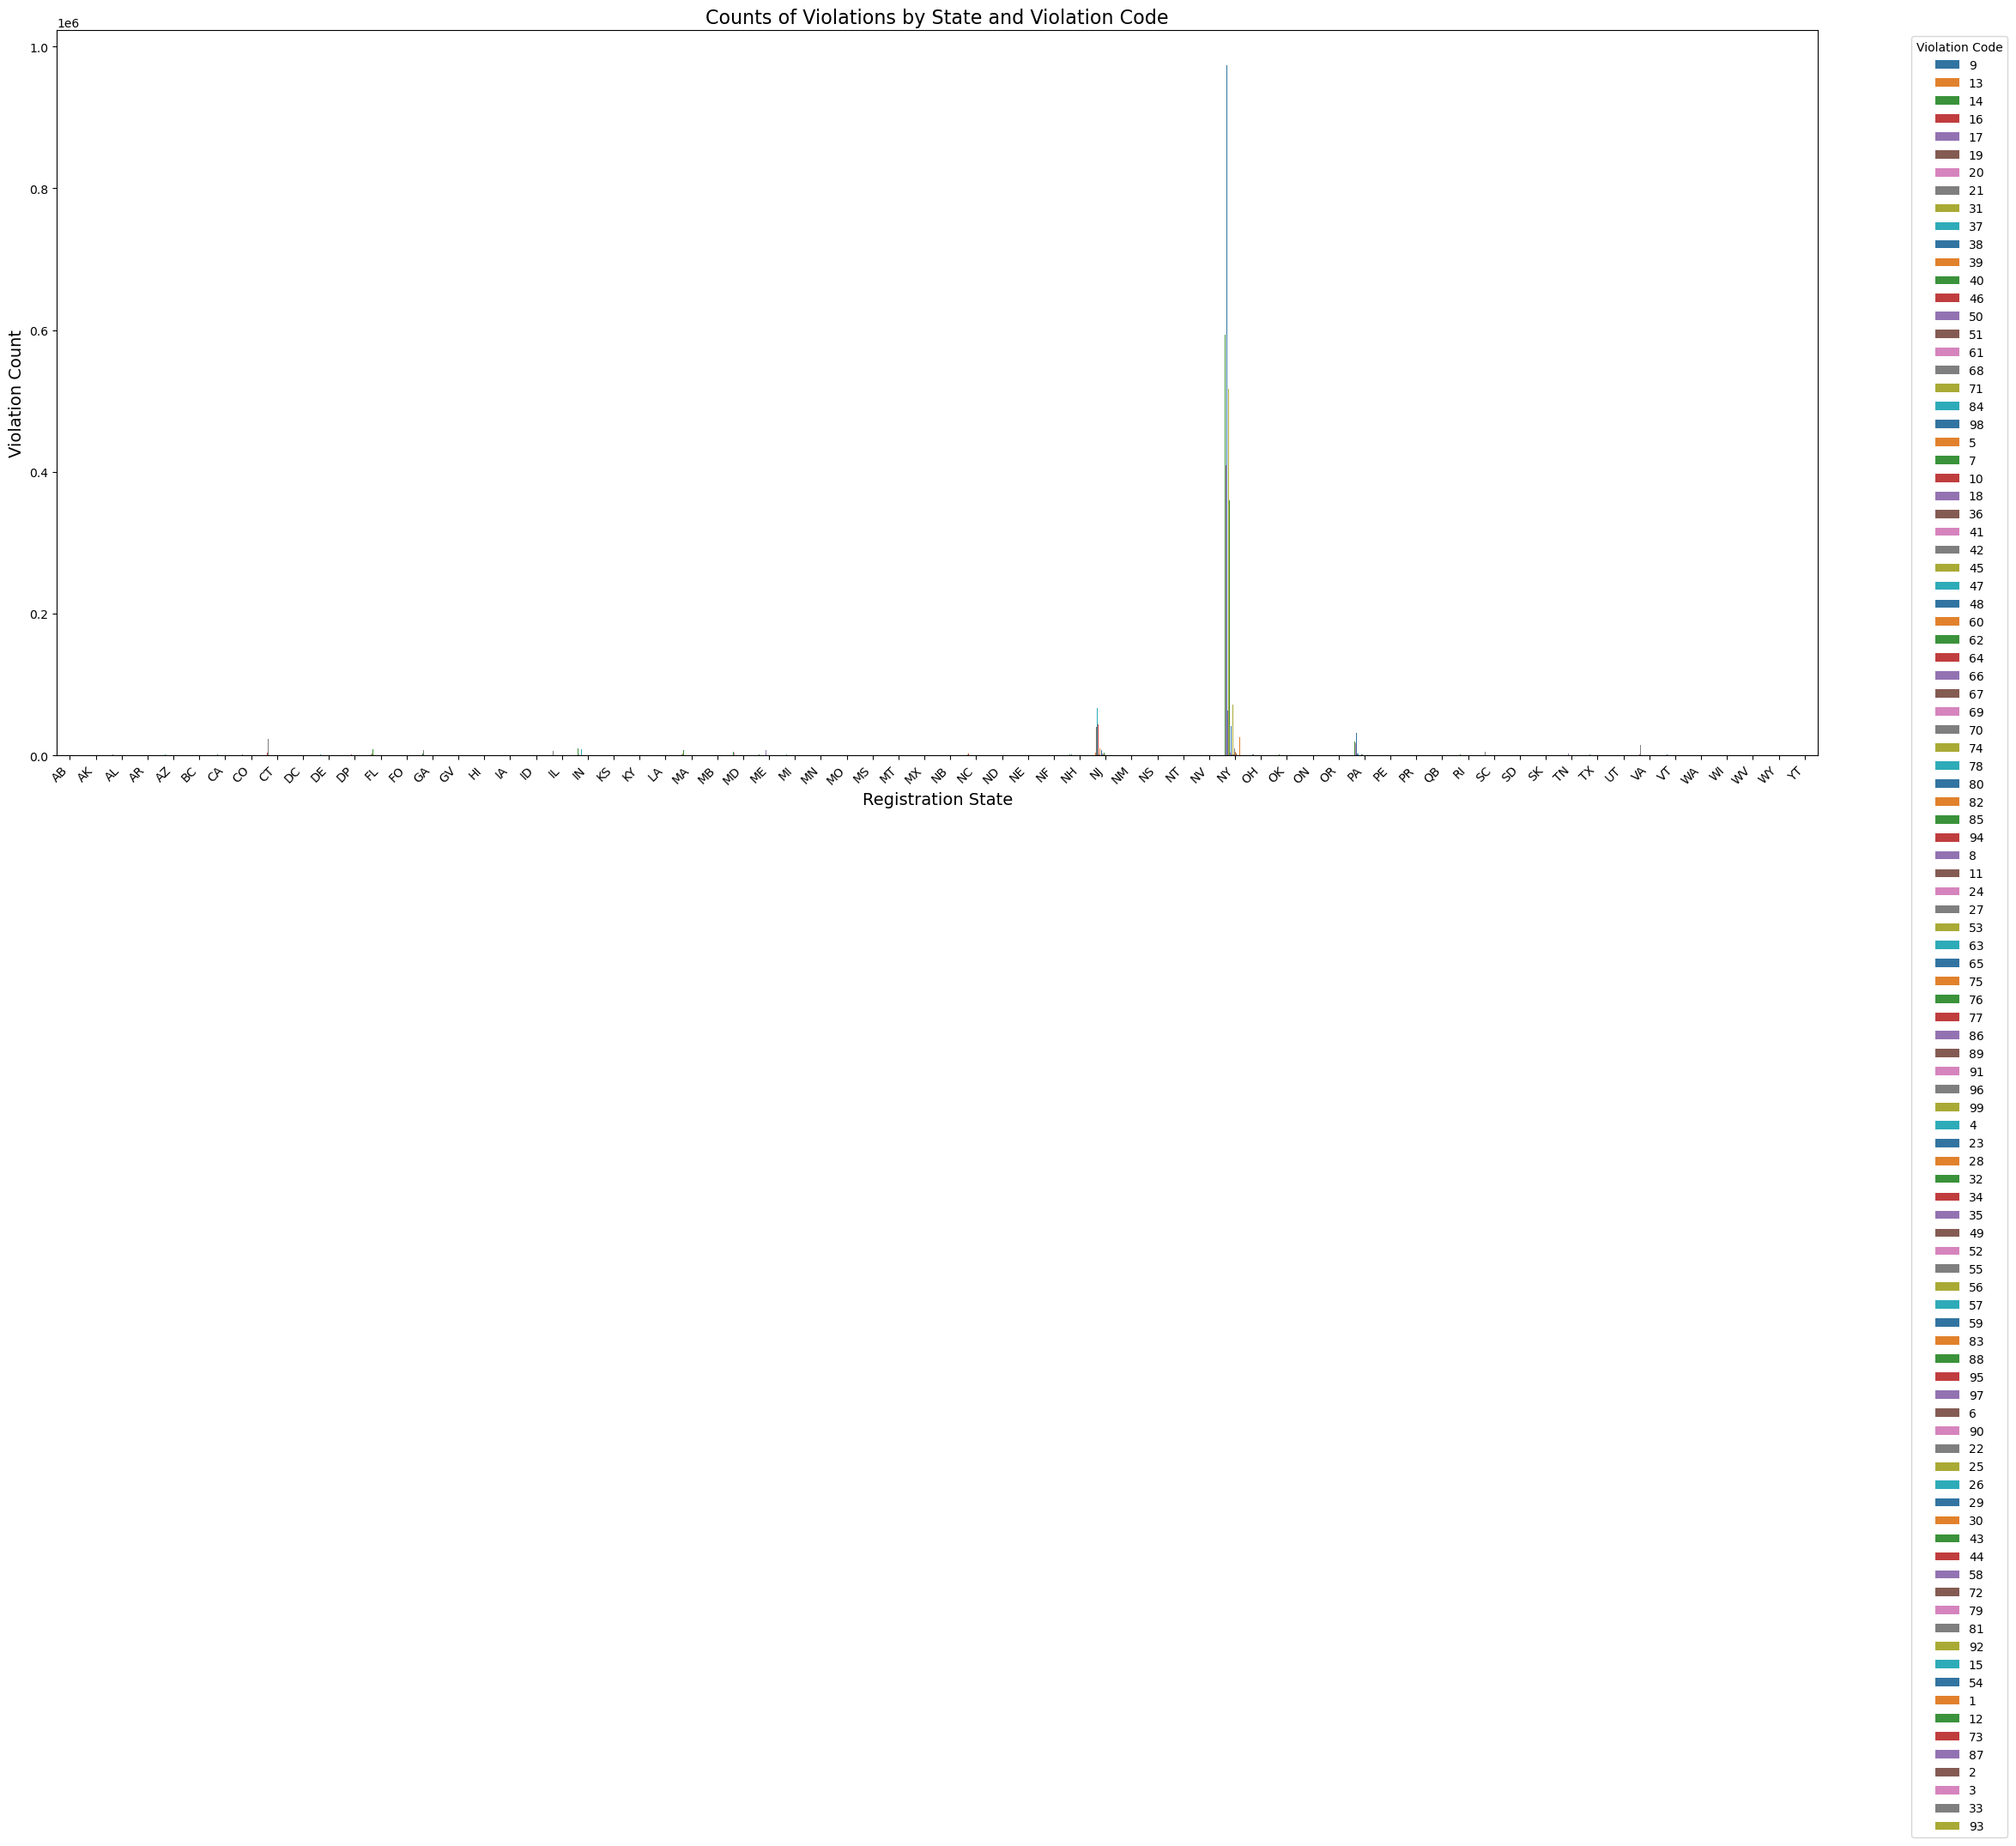

In [27]:
# Increase the figure size to provide more space for the plot
plt.figure(figsize=(24, 18))

# Create a custom color palette for the violation codes
violation_codes = violation_counts['Violation Code'].unique()  # Get unique violation codes
palette = sns.color_palette("tab10", n_colors=len(violation_codes))  # Using a different palette

# Create the barplot with 'Registration State' on the x-axis and 'Counts' on the y-axis, color-coded by 'Violation Code'
sns.barplot(
    x='Registration State',
    y='Counts',
    hue='Violation Code',
    data=violation_counts,
    palette=palette,
    hue_order=violation_codes  # Ensure the order matches the palette
)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and a title
plt.title('Counts of Violations by State and Violation Code', fontsize=16)
plt.xlabel('Registration State', fontsize=14)
plt.ylabel('Violation Count', fontsize=14)

# Move the legend outside the plot area to the right
plt.legend(title='Violation Code', bbox_to_anchor=(1.05, 1), loc='upper left')

# Manually adjust margins based on the scale of counts and to prevent clipping
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)

# Automatically adjust the padding between plot elements (if necessary)
plt.tight_layout(pad=3.0)  # Adjust layout to prevent clipping

# Show the plot
plt.show()


And a final check to see just how many violation codes there are, to make sure we got them all


In [29]:
print(violation_counts['Violation Code'].unique())

['9' '13' '14' '16' '17' '19' '20' '21' '31' '37' '38' '39' '40' '46' '50'
 '51' '61' '68' '71' '84' '98' '5' '7' '10' '18' '36' '41' '42' '45' '47'
 '48' '60' '62' '64' '66' '67' '69' '70' '74' '78' '80' '82' '85' '94' '8'
 '11' '24' '27' '53' '63' '65' '75' '76' '77' '86' '89' '91' '96' '99' '4'
 '23' '28' '32' '34' '35' '49' '52' '55' '56' '57' '59' '83' '88' '95'
 '97' '6' '90' '22' '25' '26' '29' '30' '43' '44' '58' '72' '79' '81' '92'
 '15' '54' '1' '12' '73' '87' '2' '3' '33' '93']



Third attempt at making appropriate graphics for informative purposes:


In [31]:
# Load and prepare the data
df['Registration State'] = df['Registration State'].str.strip()
df['Violation Code'] = pd.to_numeric(df['Violation Code'], errors='coerce')
df = df.dropna(subset=['Violation Code'])

# Group the data by 'Registration State' and 'Violation Code', and count the occurrences
violation_counts = df.groupby(['Registration State', 'Violation Code']).size().reset_index(name='Counts')
violation_counts['Violation Code'] = violation_counts['Violation Code'].astype(str)


After reprocessing the data for the new output requirements, we can now make our bar chart:


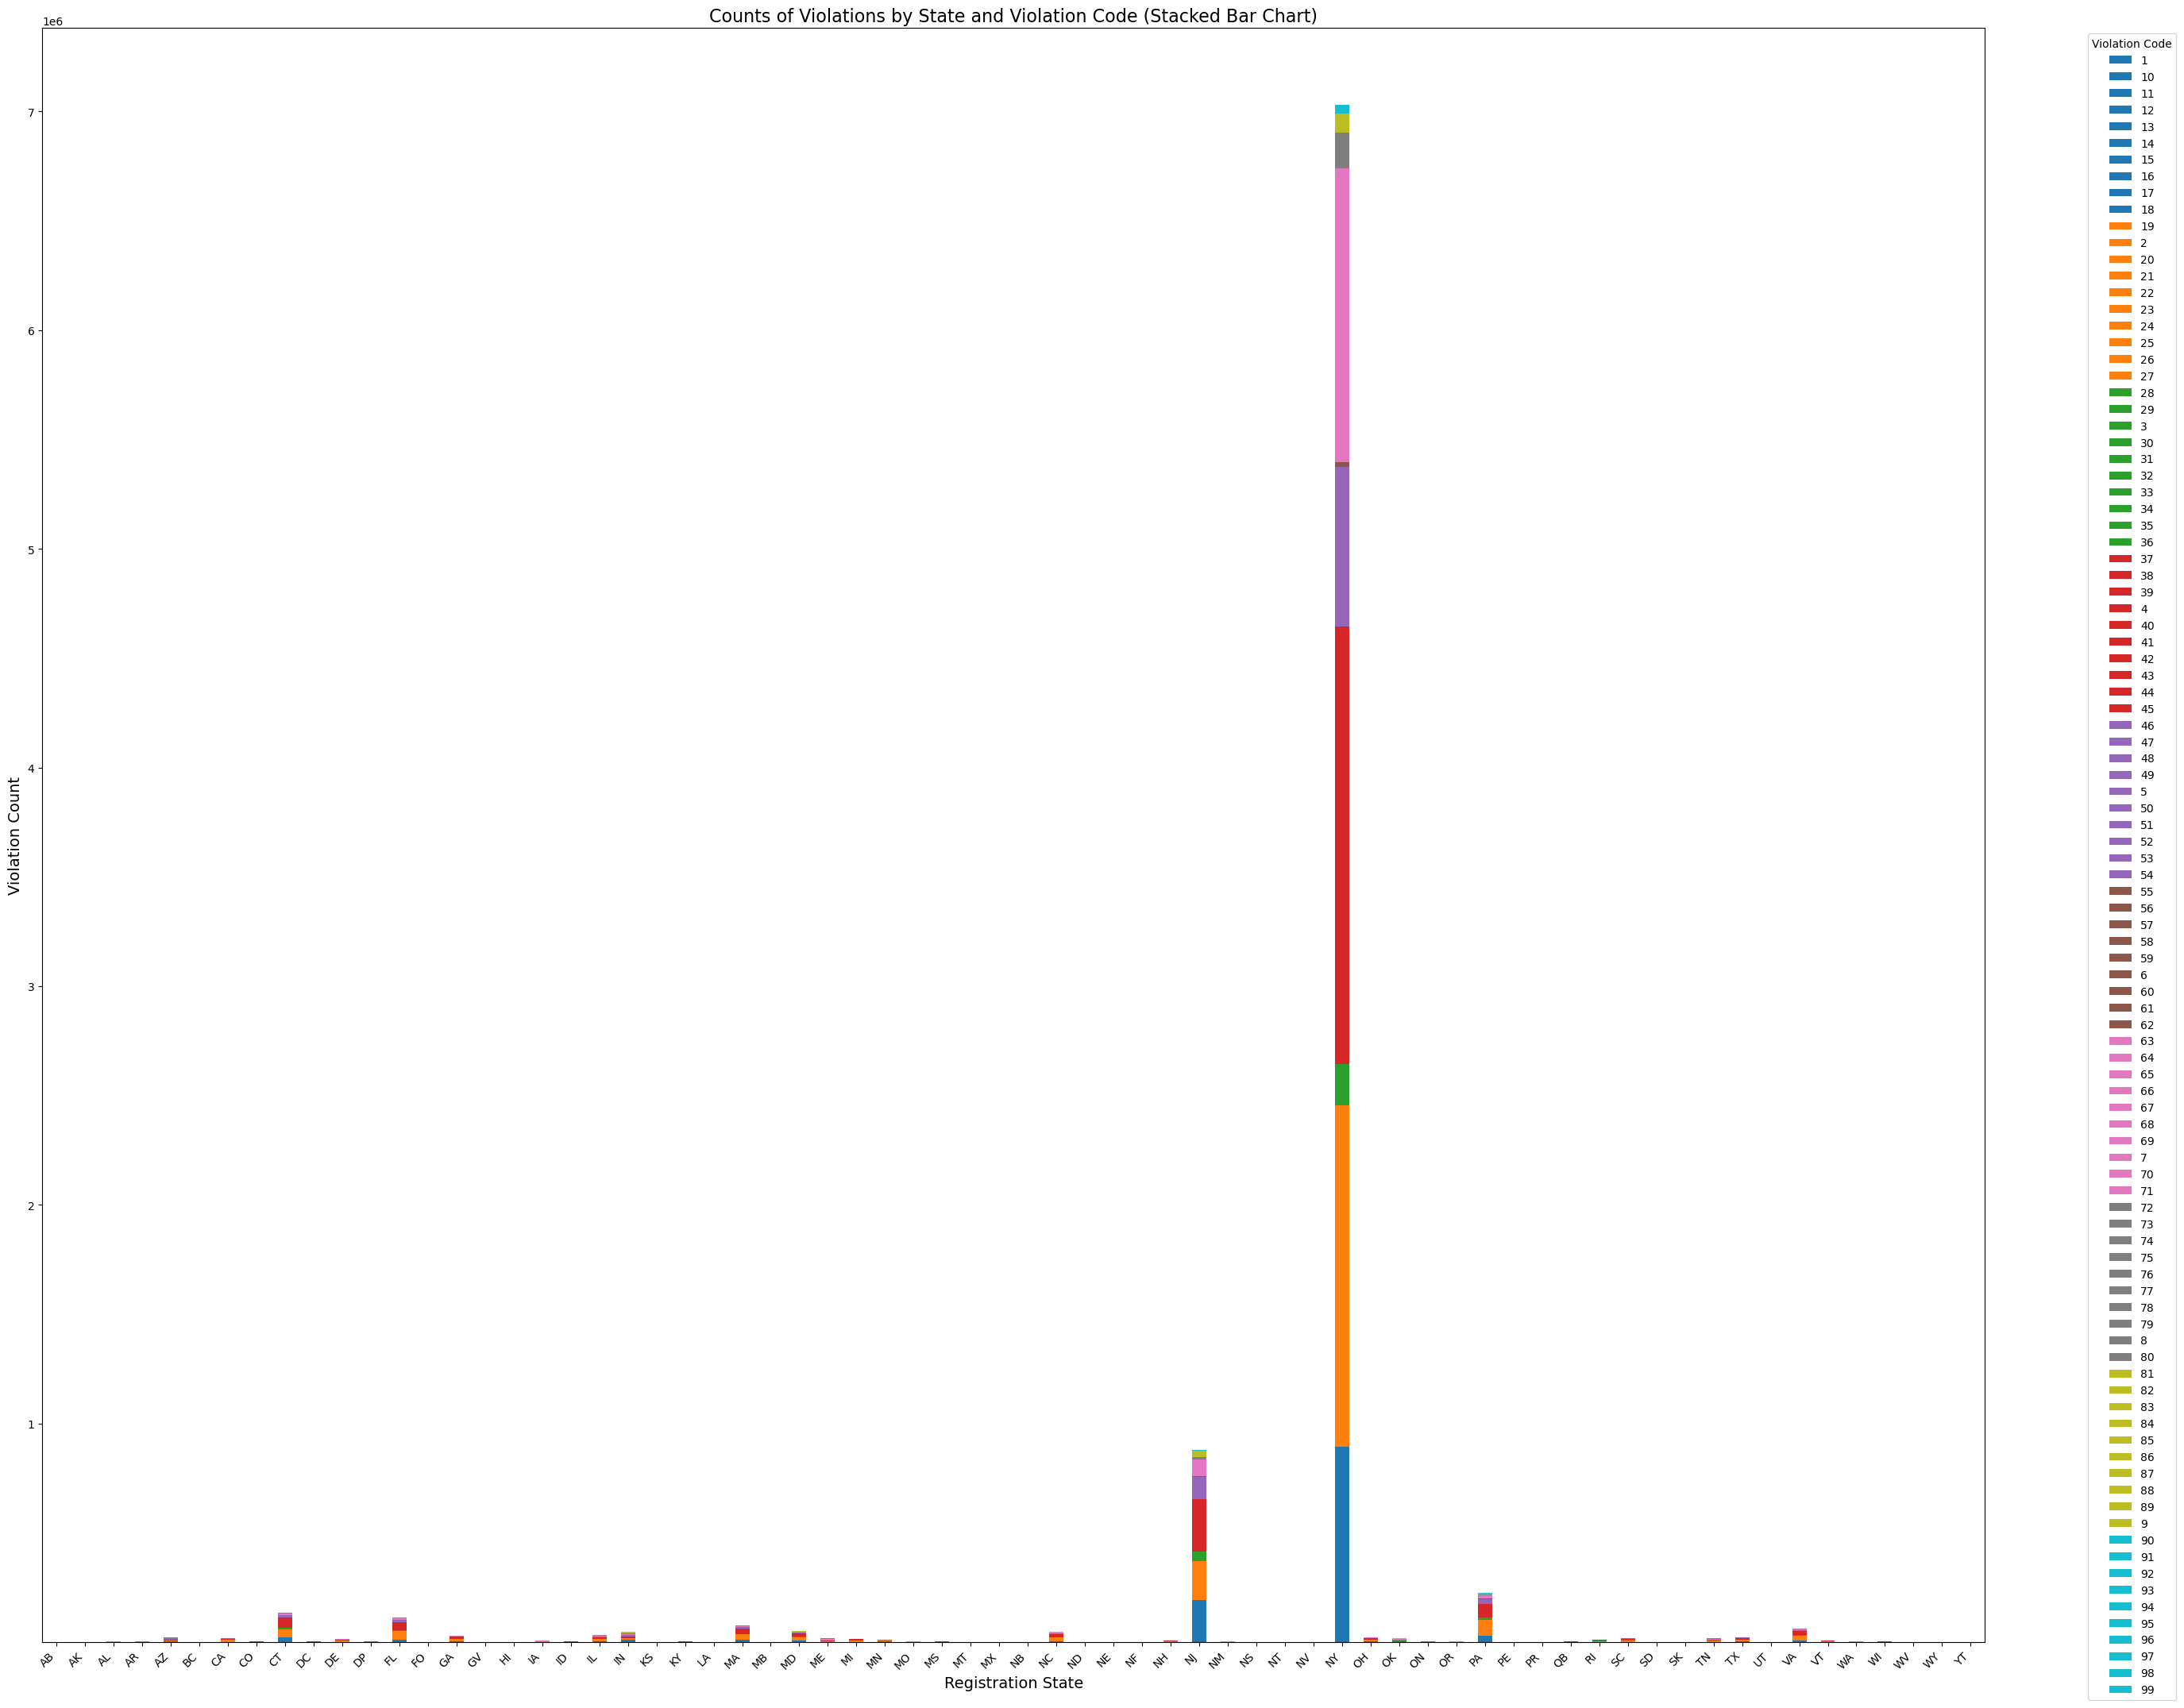

In [33]:
# Pivot the data for a stacked bar chart
pivot_counts = violation_counts.pivot(index='Registration State', columns='Violation Code', values='Counts').fillna(0)

# Plotting
ax = pivot_counts.plot(kind='bar', stacked=True, figsize=(28, 24), colormap='tab10')

# Title and labels
plt.title('Counts of Violations by State and Violation Code (Stacked Bar Chart)', fontsize=16)
plt.xlabel('Registration State', fontsize=14)
plt.ylabel('Violation Count', fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Move the legend outside the plot area to the right
plt.legend(title='Violation Code', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent clipping and provide space for the legend
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()


And the final, fourth attempt: Using a heatmap. I've included two versions, to show how the person processing the data can influence it's intended
message


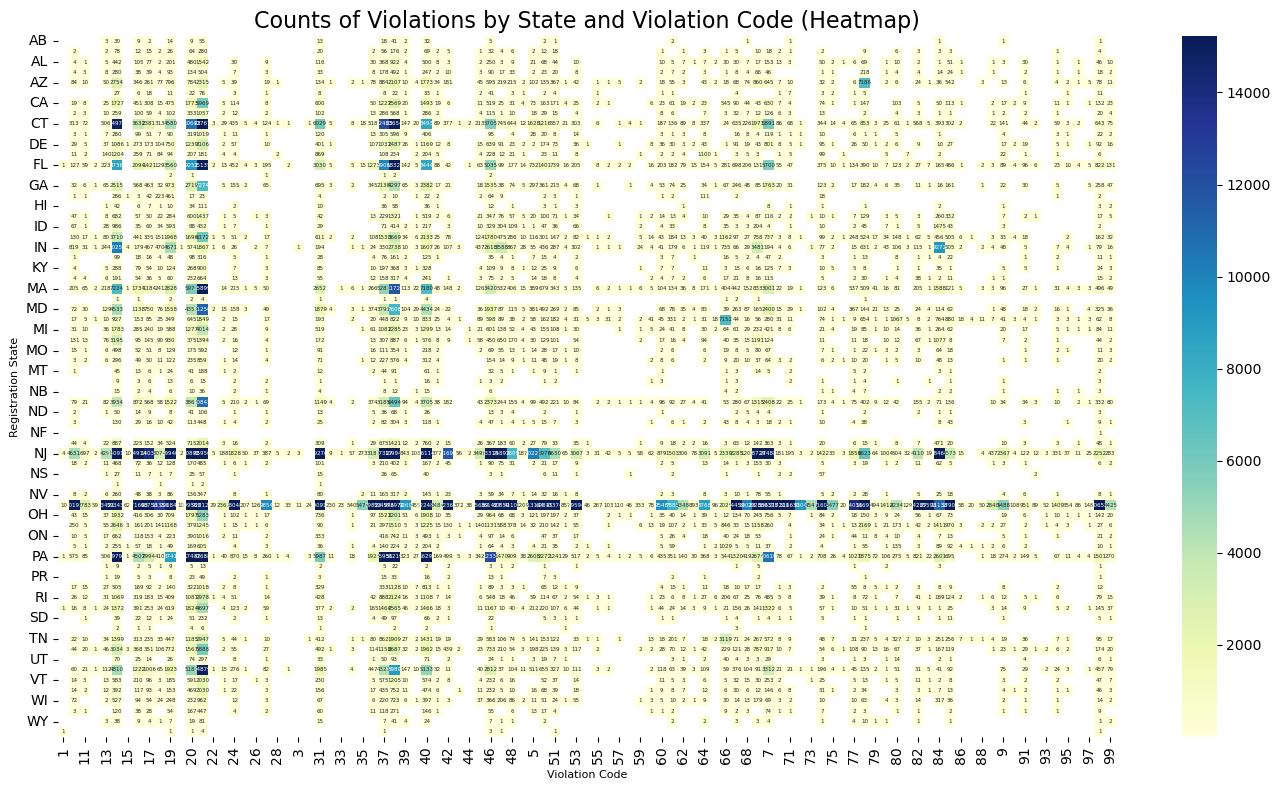

In [35]:
# Load and prepare your data (same as above)
violation_counts = df.groupby(['Registration State', 'Violation Code']).size().reset_index(name='Counts')
violation_counts['Violation Code'] = violation_counts['Violation Code'].astype(str)

# Pivot the data for a heatmap
heatmap_data = violation_counts.pivot(index='Registration State', columns='Violation Code', values='Counts')

# Find the min and max counts in the data
min_value = heatmap_data.min().min()
max_value = heatmap_data.max().max()

# Set custom min and max for the color scale, narrowing the range further
vmin = min_value
vmax = min_value + (max_value - min_value) / 64  # Adjust to a smaller range by dividing by 4

# Plotting with further adjusted color scale range
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu', annot_kws={"size": 4}, vmin=vmin, vmax=vmax)
plt.title('Counts of Violations by State and Violation Code (Heatmap)', fontsize=16)
plt.xlabel('Violation Code', fontsize=8)
plt.ylabel('Registration State', fontsize=8)
plt.tight_layout()
plt.show()

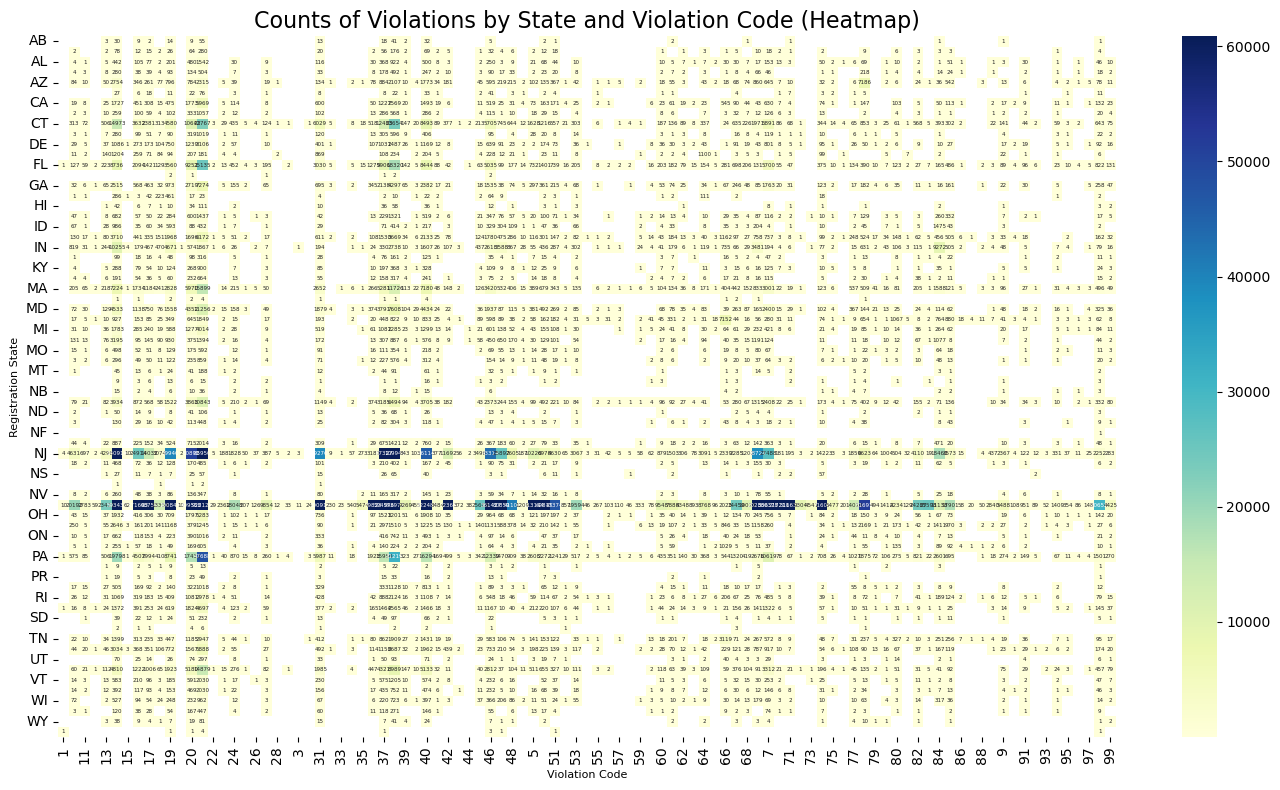

In [36]:
# Load and prepare your data (same as above)
violation_counts = df.groupby(['Registration State', 'Violation Code']).size().reset_index(name='Counts')
violation_counts['Violation Code'] = violation_counts['Violation Code'].astype(str)

# Pivot the data for a heatmap
heatmap_data = violation_counts.pivot(index='Registration State', columns='Violation Code', values='Counts')

# Find the min and max counts in the data
min_value = heatmap_data.min().min()
max_value = heatmap_data.max().max()

# Set custom min and max for the color scale, narrowing the range further
vmin = min_value
vmax = min_value + (max_value - min_value) / 16  # Adjust to a smaller range by dividing by 4

# Plotting with further adjusted color scale range
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu', annot_kws={"size": 4}, vmin=vmin, vmax=vmax)
plt.title('Counts of Violations by State and Violation Code (Heatmap)', fontsize=16)
plt.xlabel('Violation Code', fontsize=8)
plt.ylabel('Registration State', fontsize=8)
plt.tight_layout()
plt.show()


This was my first attempt


In [38]:
df = pd.read_csv('Datasets/parking_violations_issued.csv', sep=',', index_col=0, low_memory=False)
df.keys()

Index(['Plate ID', 'Registration State', 'Plate Type', 'Issue Date',
       'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency',
       'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'Number', 'Street',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

In [39]:
df = df.drop(['Plate ID','Street Code1','Plate Type','Street Code2','Street Code3','Vehicle Expiration Date','Violation Location','Violation Precinct','Issuer Code','Issuer Command','Violation In Front Of Or Opposite','Number','Street','Intersecting Street','Date First Observed','Law Section','Sub Division','Violation Legal Code','Days Parking In Effect    ','From Hours In Effect','To Hours In Effect','Meter Number','Feet From Curb','Violation Post Code','Violation Description'],axis=1)

In [40]:
df.keys()

Index(['Registration State', 'Issue Date', 'Violation Code',
       'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency',
       'Issuer Precinct', 'Issuer Squad', 'Violation Time',
       'Time First Observed', 'Violation County', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

# 

In [42]:
df.head

<bound method NDFrame.head of                Registration State  Issue Date  Violation Code  \
Summons Number                                                  
1361929741                     NY  12/18/1970              20   
1366962000                     NY  02/02/1971              46   
1342296187                     NY  09/18/1971              21   
1342296199                     TX  09/18/1971              21   
1342296217                     NY  09/18/1971              21   
...                           ...         ...             ...   
1369104972                     NY  06/26/2066              46   
1361802455                     NY  11/03/2066              46   
1365797922                     NY  01/30/2067              40   
1367760884                     CT  04/15/2067              40   
1356701073                     NY  12/23/2069              40   

               Vehicle Body Type Vehicle Make Issuing Agency  Issuer Precinct  \
Summons Number                             

In [43]:
# Strip any extra spaces from 'Registration State' to avoid mismatches
df['Registration State'] = df['Registration State'].str.strip()

# Optionally, check if there are any missing values in important columns
print(df[['Registration State', 'Violation Code']].isnull().sum())

Registration State    0
Violation Code        0
dtype: int64


In [44]:
df['Violation Code'] = pd.to_numeric(df['Violation Code'], errors='coerce')  # 'coerce' will convert invalid values to NaN

In [45]:
# Check for any NaN values in 'Violation Code' after conversion
print(df['Violation Code'].isnull().sum())

0


In [46]:
df_cleaned = df[df['Registration State'] != '99']

In [47]:
print(df_cleaned['Registration State'].unique())

['NY' 'TX' 'VA' 'NJ' 'ME' 'SC' 'CT' 'IL' 'MA' 'PA' 'FL' 'GV' 'TN' 'NC'
 'AZ' 'IN' 'MD' 'DE' 'VT' 'ID' 'KS' 'OH' 'GA' 'CA' 'WA' 'NH' 'RI' 'LA'
 'NM' 'AL' 'OK' 'CO' 'DC' 'AR' 'MI' 'MS' 'ON' 'MN' 'WI' 'WV' 'OR' 'ND'
 'DP' 'SD' 'IA' 'MO' 'NS' 'NE' 'KY' 'UT' 'QB' 'NV' 'MT' 'AK' 'WY' 'HI'
 'MX' 'SK' 'BC' 'AB' 'PR' 'PE' 'NB' 'MB' 'FO' 'NT' 'YT' 'NF']


In [48]:
df = df_cleaned

# Check if there are any missing values in 'Violation Code'
print(df['Violation Code'].isnull().sum())

# Check the unique values in 'Violation Code' to identify any odd values
print(df['Violation Code'].unique())

0
[20 46 21 40 14 59 31 66 78 98 99 71 70 67 19 45 51 74 49 16 47 50 60 10
 62 68 17 27 18 94 77 88 80 38 41 48 24 37  5 34 53 75 83 85 90 96  9 15
 29 95 91 52 84 42 79 61 22 86 89 64 73 82 39  8 55 11 43 65  7 63  6 93
 81 26 72 76 13 58 57 23 56  4 69  3  1 97 92 54 30 12 25 35 36 32 87 33
 28  2 44  0]


In [49]:
# Filter out rows where 'Violation Code' is 0 or any other invalid values
df_cleaned = df_cleaned[df_cleaned['Violation Code'] != 0]

In [50]:
df = df_cleaned

# Group by 'Registration State' and 'Violation Code' again after cleaning
violation_counts = df_cleaned.groupby(['Registration State', 'Violation Code']).size().reset_index(name='Counts')

# Check the result
print(violation_counts.head())

  Registration State  Violation Code  Counts
0                 AB               9       1
1                 AB              13       3
2                 AB              14      30
3                 AB              16       9
4                 AB              17       2


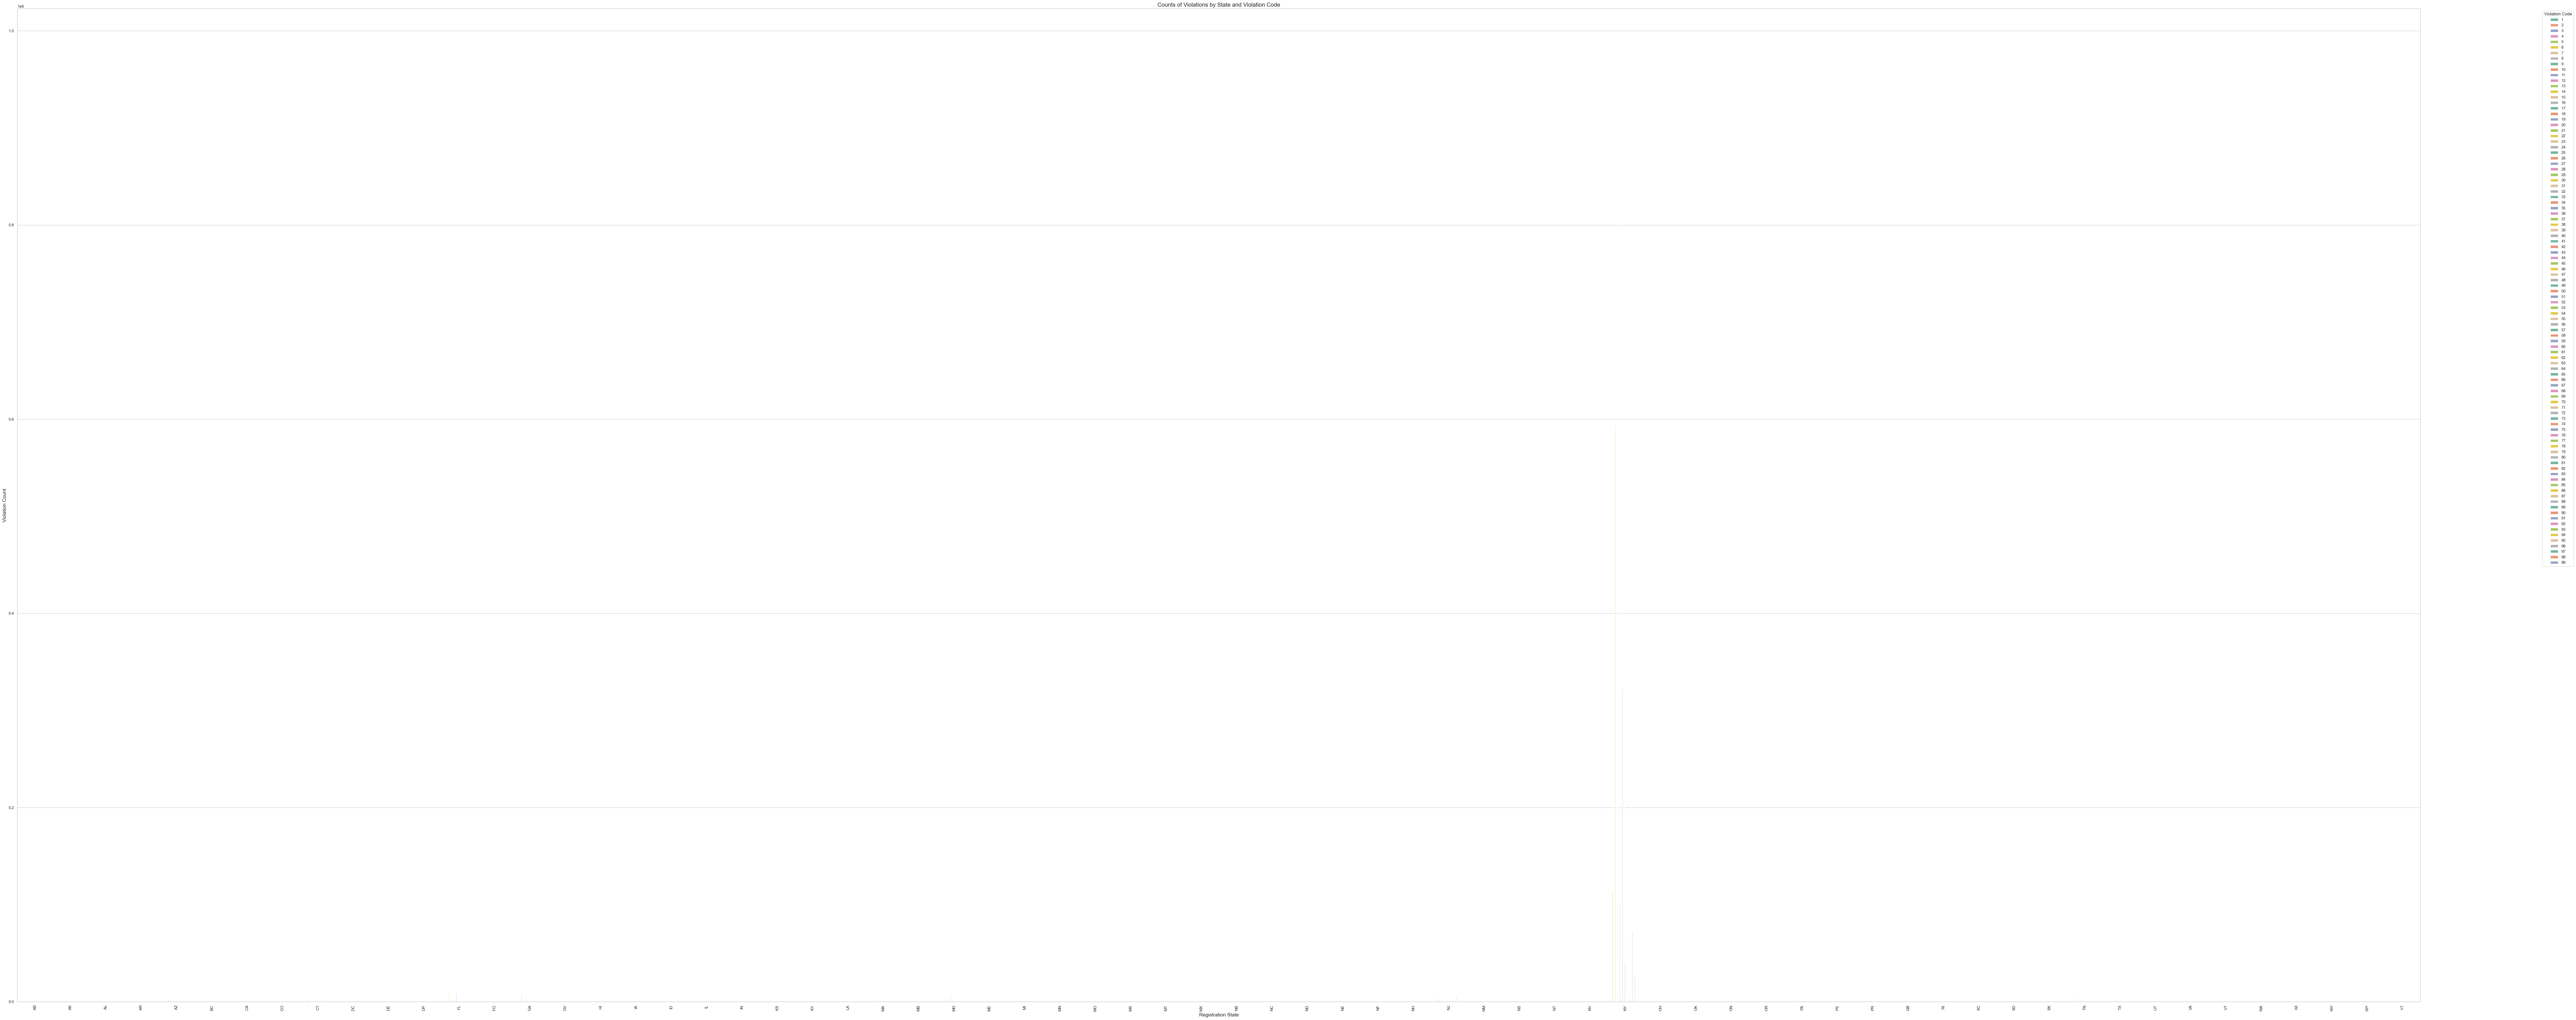

In [51]:
# Set the plot style
sns.set(style="whitegrid")

# Create the barplot
plt.figure(figsize=(100, 40))
sns.barplot(x='Registration State', y='Counts', hue='Violation Code', data=violation_counts, palette='Set2')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and a title
plt.title('Counts of Violations by State and Violation Code', fontsize=16)
plt.xlabel('Registration State', fontsize=14)
plt.ylabel('Violation Count', fontsize=14)

# Show the legend and the plot
plt.legend(title='Violation Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [52]:
total_entries = len(df)

# Count the number of entries where the 'Registration State' is 'NY' (New York)
ny_entries = df[df['Registration State'] == 'NY'].shape[0]

# Calculate the percentage of entries from New York
ny_percentage = (ny_entries / total_entries) * 100

In [53]:
print(total_entries)
print(ny_percentage)

9062175
77.57283433612791


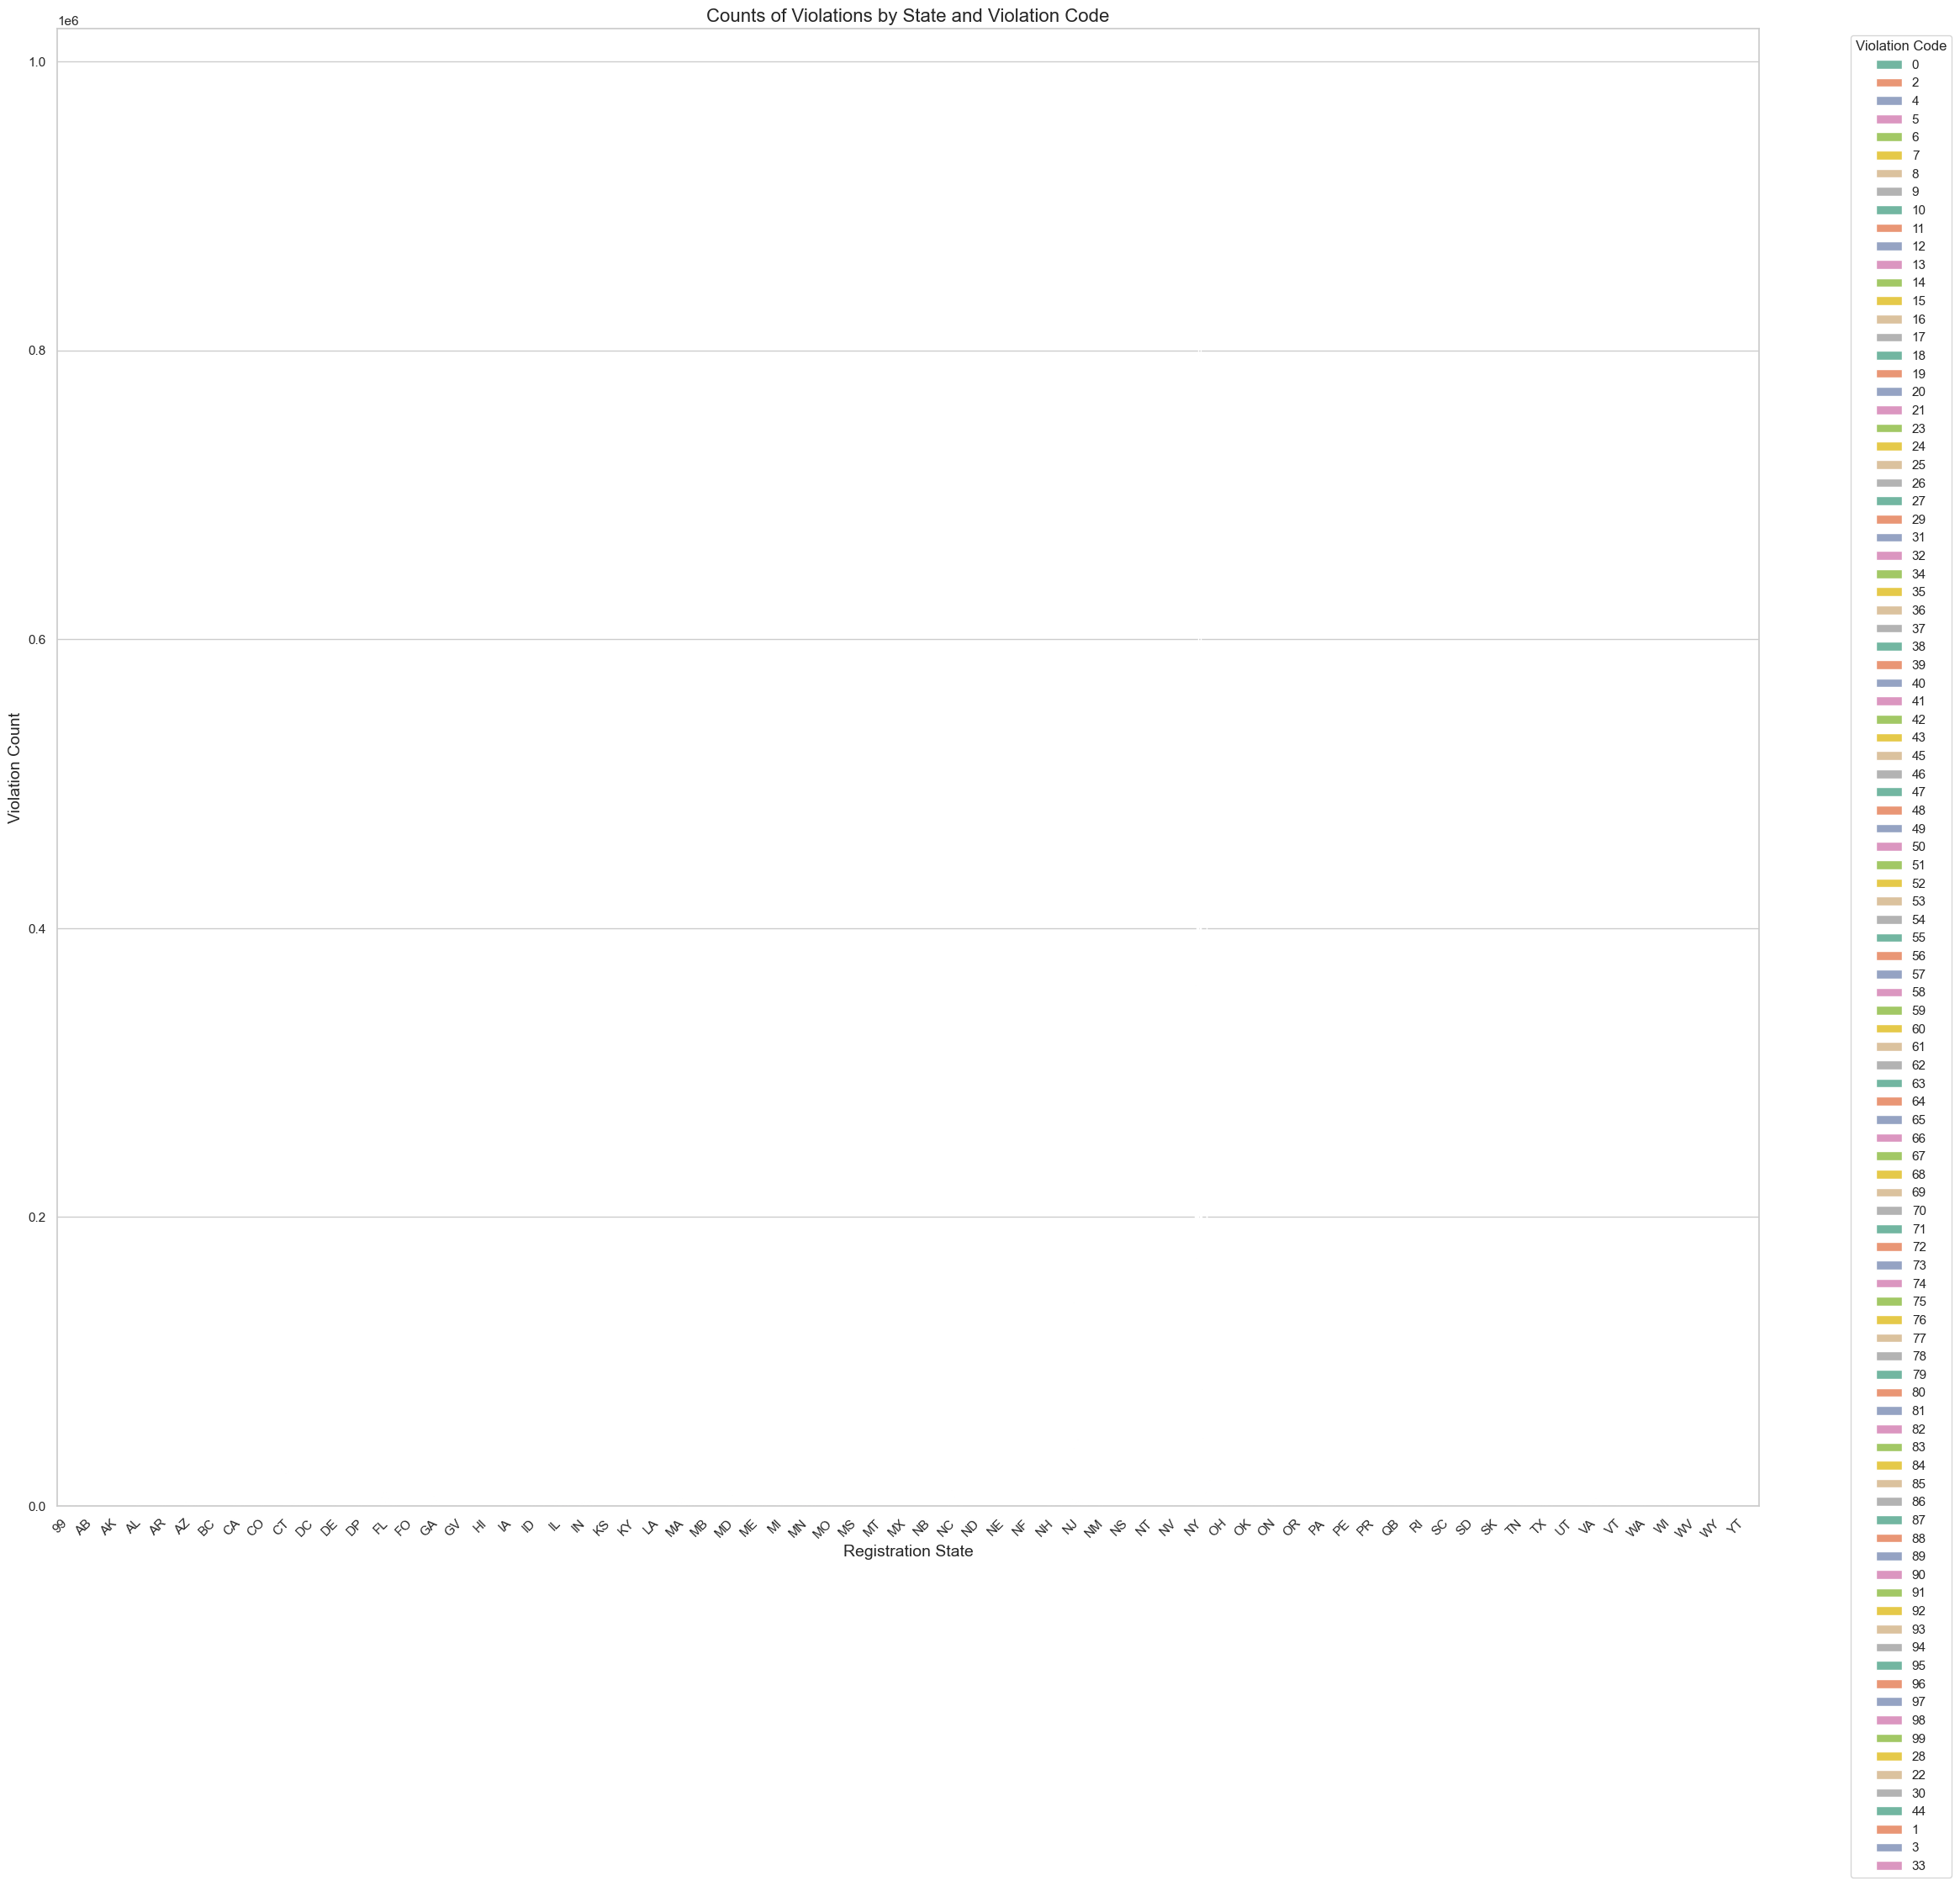

In [55]:
# Load your data with the new file path
df = pd.read_csv('Datasets/Parking_Violations_Issued.csv', sep=',', index_col=0, low_memory=False)

# Clean up data: Convert 'Registration State' to string and strip extra spaces
df['Registration State'] = df['Registration State'].str.strip()

# Convert 'Violation Code' to numeric, and handle any errors as NaN (then drop NaNs)
df['Violation Code'] = pd.to_numeric(df['Violation Code'], errors='coerce')
df = df.dropna(subset=['Violation Code'])  # Drop rows with NaN values in 'Violation Code'

# Group the data by 'Registration State' and 'Violation Code' and count occurrences
violation_counts = df.groupby(['Registration State', 'Violation Code']).size().reset_index(name='Counts')

# Filter out states with zero violations (if any exist, though this should already be clean)
violation_counts = violation_counts[violation_counts['Counts'] > 0]

# Ensure that 'Violation Code' is treated as a categorical variable (string type)
violation_counts['Violation Code'] = violation_counts['Violation Code'].astype(str)

# Increase the figure size to provide more space for the plot
plt.figure(figsize=(24, 24))

# Create a custom color palette for the violation codes
violation_codes = violation_counts['Violation Code'].unique()  # Get unique violation codes
palette = sns.color_palette("Set2", len(violation_codes))  # Create palette based on the unique codes

# Create the barplot with 'Registration State' on the x-axis and 'Counts' on the y-axis, color-coded by 'Violation Code'
sns.barplot(x='Registration State', y='Counts', hue='Violation Code', data=violation_counts,
            palette=palette, hue_order=violation_codes)  # Ensure correct color mapping

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and a title
plt.title('Counts of Violations by State and Violation Code', fontsize=16)
plt.xlabel('Registration State', fontsize=14)
plt.ylabel('Violation Count', fontsize=14)

# Move the legend outside the plot area to the right
plt.legend(title='Violation Code', bbox_to_anchor=(1.05, 1), loc='upper left')

# Manually adjust margins based on the scale of counts and to prevent clipping
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)

# Automatically adjust the padding between plot elements (if necessary)
plt.tight_layout(pad=3.0)  # Adjust layout to prevent clipping

# Show the plot
plt.show()